In [20]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

# MLflow Setup for Bidirectional GRU Model Tracking

In [21]:
# Import MLflow for experiment tracking
import mlflow
import mlflow.tensorflow
import os

# Set MLflow tracking URI first
mlflow.set_tracking_uri("sqlite:///mlflow.db")

# Create or get the experiment
experiment_name = "model_experiment"
try:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        experiment_id = mlflow.create_experiment(experiment_name)
        print(f"Created new experiment '{experiment_name}' with ID: {experiment_id}")
    else:
        experiment_id = experiment.experiment_id
        print(f"Using existing experiment '{experiment_name}' with ID: {experiment_id}")
    
    mlflow.set_experiment(experiment_name)
    print(f"MLflow experiment '{experiment_name}' is set up for Bidirectional GRU tracking")
except Exception as e:
    print(f"Error setting up MLflow experiment: {e}")
    # Fallback: just set the experiment (will create if not exists)
    mlflow.set_experiment(experiment_name)
    print(f"MLflow experiment '{experiment_name}' is set up (fallback method)")

Using existing experiment 'model_experiment' with ID: 1
MLflow experiment 'model_experiment' is set up for Bidirectional GRU tracking


In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

sns.set()
tf.compat.v1.random.set_random_seed(1234)
np.random.seed(1234)

# Load Data - Using Same Dataset as Other Models

In [23]:
# Load the same data as other models for comparison
df = pd.read_csv('./vgi2.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (854, 6)


,date,close,open,high,low,nmVolume
0,2018-09-25,21.0,21.0,21.0,16.0,1816800.0
1,2018-09-26,23.9,23.9,23.9,23.8,214200.0
2,2018-09-27,27.4,27.4,27.4,27.4,388100.0
3,2018-09-28,28.2,31.5,31.5,27.4,2111074.0
4,2018-10-01,26.8,29.5,29.6,25.8,831097.0


In [24]:
# Use Close price for prediction (same as other models)
close_data = df[['close']].astype('float32')
print(f"Close price data shape: {close_data.shape}")

# Scale the data
minmax = MinMaxScaler()
df_scaled = minmax.fit_transform(close_data)
df_log = pd.DataFrame(df_scaled, columns=['close'])
print(f"Scaled data shape: {df_log.shape}")
df_log.head()

Close price data shape: (854, 1)
Scaled data shape: (854, 1)


,close
0,0.253521
1,0.335211
2,0.433803
3,0.456338
4,0.416901


## Split Data into Train/Validation/Test Sets

Using the same split strategy as other models for fair comparison:
- Train: 70% of data 
- Test: 20% of data

This ensures consistent evaluation for training parameters and test metrics only.

In [25]:
# Calculate split indices - 80% train / 20% test (no validation)
total_len = len(df_log)
train_len = int(0.8 * total_len)  # 80% for training
test_len = total_len - train_len  # 20% for test

print(f"Total samples: {total_len}")
print(f"Train samples: {train_len}")
print(f"Test samples: {test_len}")
print(f"Train percentage: {train_len/total_len*100:.1f}%")
print(f"Test percentage: {test_len/total_len*100:.1f}%")

# Create splits
df_train = df_log.iloc[:train_len]
df_test = df_log.iloc[train_len:]

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Train period: {df_train.index[0]} to {df_train.index[-1]}")
print(f"Test period: {df_test.index[0]} to {df_test.index[-1]}")

Total samples: 854
Train samples: 683
Test samples: 171
Train percentage: 80.0%
Test percentage: 20.0%
Train shape: (683, 1)
Test shape: (171, 1)
Train period: 0 to 682
Test period: 683 to 853


# Utility Functions and Model Definition

In [26]:
def create_sequences(data, time_steps=5):
    """Create sequences for time series prediction"""
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

def calculate_metrics(y_true, y_pred):
    """Calculate evaluation metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # MAPE calculation with protection against division by zero
    y_true_safe = np.where(np.abs(y_true) < 1e-8, 1e-8, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100
    
    return mse, rmse, mae, r2, mape

def calculate_accuracy(real, predict):
    """Calculate percentage accuracy"""
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    """Apply exponential smoothing"""
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [27]:
class BiGRUModel:
    def __init__(
        self,
        learning_rate=0.01,
        num_layers=1,
        input_size=1,
        hidden_size=128,
        output_size=1,
        dropout_rate=0.2,
        time_steps=5
    ):
        # Model parameters
        self.learning_rate = learning_rate
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_rate = dropout_rate
        self.time_steps = time_steps
        
        # Build the model
        self._build_model()
        
    def _build_model(self):
        """Build the bidirectional GRU model"""
        # Clear any existing graphs
        tf.keras.backend.clear_session()
        
        # Input layer
        inputs = tf.keras.layers.Input(shape=(self.time_steps, self.input_size))
        
        # Bidirectional GRU layers
        x = inputs
        for i in range(self.num_layers):
            return_sequences = (i < self.num_layers - 1)  # Return sequences for all but last layer
            
            x = tf.keras.layers.Bidirectional(
                tf.keras.layers.GRU(
                    self.hidden_size,
                    return_sequences=return_sequences,
                    dropout=self.dropout_rate,
                    recurrent_dropout=self.dropout_rate
                )
            )(x)
            
            # Add dropout between layers
            if i < self.num_layers - 1:
                x = tf.keras.layers.Dropout(self.dropout_rate)(x)
        
        # Output layer
        outputs = tf.keras.layers.Dense(self.output_size)(x)
        
        # Create and compile model
        self.model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.model.compile(
            optimizer=optimizer,
            loss='mse',
            metrics=['mae']
        )
        
    def get_model_summary(self):
        """Get model summary"""
        return self.model.summary()
    
    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=100, batch_size=32, verbose=1):
        """Train the model"""
        validation_data = (X_val, y_val) if X_val is not None and y_val is not None else None
        
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss' if validation_data else 'loss',
                patience=20,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss' if validation_data else 'loss',
                factor=0.5,
                patience=10,
                min_lr=1e-6
            )
        ]
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=validation_data,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=verbose
        )
        
        return history
    
    def predict(self, X):
        """Make predictions"""
        return self.model.predict(X)
    
    def save(self, filepath):
        """Save the model"""
        self.model.save(filepath)
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

# Model Hyperparameters

In [28]:
# Model hyperparameters
TIME_STEPS = 6  # Same as other models for consistency
HIDDEN_SIZE = 128
NUM_LAYERS = 1
LEARNING_RATE = 0.01
EPOCHS = 100
BATCH_SIZE = 32
DROPOUT_RATE = 0.2

# Display hyperparameters
print("Bidirectional GRU Model Hyperparameters:")
print(f"Time Steps: {TIME_STEPS}")
print(f"Hidden Size: {HIDDEN_SIZE}")
print(f"Number of Layers: {NUM_LAYERS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Dropout Rate: {DROPOUT_RATE}")

Bidirectional GRU Model Hyperparameters:
Time Steps: 6
Hidden Size: 128
Number of Layers: 1
Learning Rate: 0.01
Epochs: 100
Batch Size: 32
Dropout Rate: 0.2

Time Steps: 6
Hidden Size: 128
Number of Layers: 1
Learning Rate: 0.01
Epochs: 100
Batch Size: 32
Dropout Rate: 0.2


# Data Preparation for Training

In [29]:
# Prepare sequences for training and testing (no validation)
print("Preparing sequences...")

# Create sequences for each dataset
X_train, y_train = create_sequences(df_train.values.flatten(), TIME_STEPS)
X_test, y_test = create_sequences(df_test.values.flatten(), TIME_STEPS)

# Reshape for the model (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Training sequences: {X_train.shape}, {y_train.shape}")
print(f"Test sequences: {X_test.shape}, {y_test.shape}")

# Create date arrays for plotting
train_dates = df_train.index[TIME_STEPS:]
test_dates = df_test.index[TIME_STEPS:]

print(f"Training period: {train_dates[0]} to {train_dates[-1]}")
print(f"Test period: {test_dates[0]} to {test_dates[-1]}")

Preparing sequences...
Training sequences: (677, 6, 1), (677,)
Test sequences: (165, 6, 1), (165,)
Training period: 6 to 682
Test period: 689 to 853


# Model Training and Evaluation

In [30]:
# Create and train the Bidirectional GRU model
print("Creating Bidirectional GRU model...")

model = BiGRUModel(
    learning_rate=LEARNING_RATE,
    num_layers=NUM_LAYERS,
    input_size=1,
    hidden_size=HIDDEN_SIZE,
    output_size=1,
    dropout_rate=DROPOUT_RATE,
    time_steps=TIME_STEPS
)

# Display model architecture
model.get_model_summary()

Creating Bidirectional GRU model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       100,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,865 (394.00 KB)

 Trainable params: 100,865 (394.00 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Train the model (no validation data)
print("Training the model...")

history = model.train(
    X_train, y_train,
    None, None,  # No validation data
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

print("Training completed!")

Training the model...
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0555 - mae: 0.1750 - learning_rate: 0.0100
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0555 - mae: 0.1750 - learning_rate: 0.0100
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0212 - mae: 0.1104 - learning_rate: 0.0100
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0212 - mae: 0.1104 - learning_rate: 0.0100
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0171 - mae: 0.1027 - learning_rate: 0.0100
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0171 - mae: 0.1027 - learning_rate: 0.0100
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0184 - mae: 0.0995 - learning_rate: 0.0100
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0184 - mae: 0.0995 - learning_rate: 0.0100
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0177 - mae: 0.1037 - learning_rate: 0.0100
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━

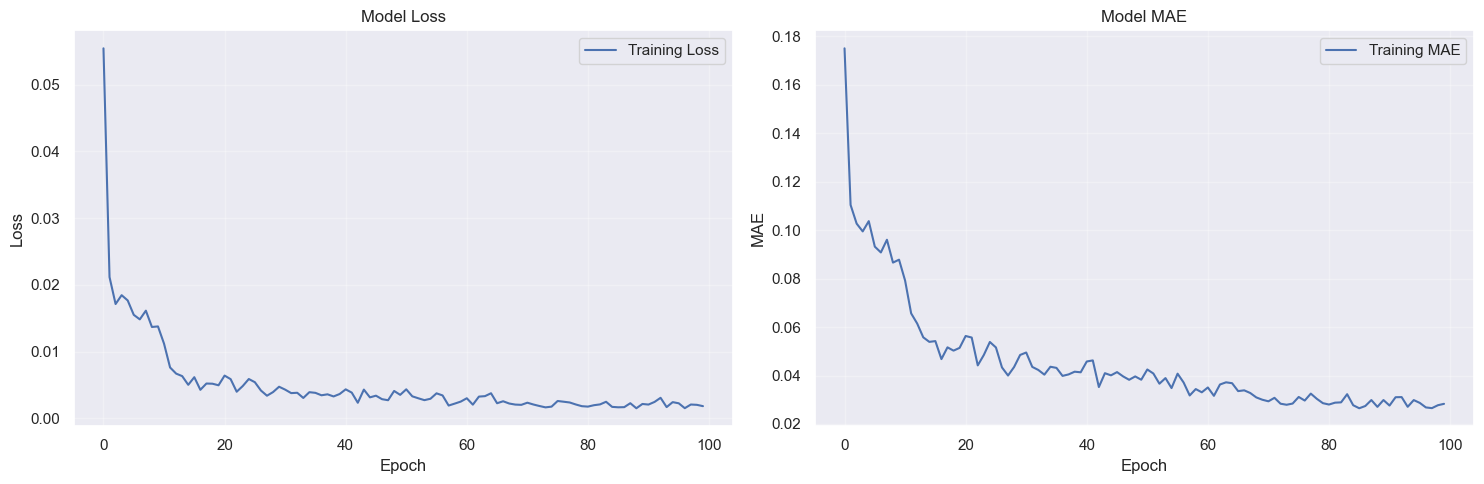

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


Model saved as 'bidirectional_gru_model.h5'


In [32]:
# Plot training history (training only)
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the model
model.save('bidirectional_gru_model.h5')
print("Model saved as 'bidirectional_gru_model.h5'")

# Model Evaluation and MLflow Tracking

In [33]:
# Make predictions on train and test sets
print("Making predictions...")

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_train_actual = minmax.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_train_pred_actual = minmax.inverse_transform(y_train_pred).flatten()

y_test_actual = minmax.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_test_pred_actual = minmax.inverse_transform(y_test_pred).flatten()

print(f"Training predictions shape: {y_train_pred_actual.shape}")
print(f"Test predictions shape: {y_test_pred_actual.shape}")

Making predictions...
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training predictions shape: (677,)
Test predictions shape: (165,)
Training predictions shape: (677,)
Test predictions shape: (165,)


In [34]:
# Calculate metrics for training and test sets
train_mse, train_rmse, train_mae, train_r2, train_mape = calculate_metrics(y_train_actual, y_train_pred_actual)
test_mse, test_rmse, test_mae, test_r2, test_mape = calculate_metrics(y_test_actual, y_test_pred_actual)

print("Training Metrics:")
print(f"MSE: {train_mse:.5f}, RMSE: {train_rmse:.5f}, MAE: {train_mae:.5f}")
print(f"R²: {train_r2:.5f}, MAPE: {train_mape:.3f}%")

print("\nTest Metrics:")
print(f"MSE: {test_mse:.5f}, RMSE: {test_rmse:.5f}, MAE: {test_mae:.5f}")
print(f"R²: {test_r2:.5f}, MAPE: {test_mape:.3f}%")

Training Metrics:
MSE: 13.42616, RMSE: 3.66417, MAE: 3.34835
R²: 0.72180, MAPE: 11.641%

Test Metrics:
MSE: 18.42581, RMSE: 4.29253, MAE: 4.20699
R²: -1.31733, MAPE: 12.565%


In [35]:
# MLflow tracking - Bidirectional GRU Combined Training and Evaluation (80/20 Split)
with mlflow.start_run(run_name="BiGRU_Training") as bigru_run:
    print(f"Starting Bidirectional GRU run: {bigru_run.info.run_id}")
    
    # Log model parameters
    mlflow.log_param("model_type", "Bidirectional GRU")
    mlflow.log_param("architecture", "BiGRU")
    mlflow.log_param("time_steps", TIME_STEPS)
    mlflow.log_param("hidden_size", HIDDEN_SIZE)
    mlflow.log_param("num_layers", NUM_LAYERS)
    mlflow.log_param("dropout_rate", DROPOUT_RATE)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("test_size", len(X_test))
    mlflow.log_param("split_ratio", "80/20")
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("loss_function", "mean_squared_error")
    
    # Log training metrics
    mlflow.log_metric("mse_training", train_mse)
    mlflow.log_metric("rmse_training", train_rmse)
    mlflow.log_metric("mae_training", train_mae)
    mlflow.log_metric("r2_training", train_r2)
    mlflow.log_metric("mape_training", train_mape)
    
    # Log test metrics with consistent naming (same as other models)
    mlflow.log_metric("mse_test", test_mse)
    mlflow.log_metric("rmse_test", test_rmse)
    mlflow.log_metric("mae_test", test_mae)
    mlflow.log_metric("r2_test", test_r2)
    mlflow.log_metric("mape_test", test_mape)
    
    # Log model artifacts with descriptive name
    mlflow.tensorflow.log_model(model.model, "BiGRU_Stock_Predictor")
    
    # Create and save test predictions
    test_predictions_df = pd.DataFrame({
        'actual': y_test_actual.flatten(),
        'predicted': y_test_pred_actual.flatten()
    })
    test_predictions_df.to_csv("bigru_test_predictions.csv", index=False)
    mlflow.log_artifact("bigru_test_predictions.csv")
    
    print(f"Bidirectional GRU Combined Metrics:")
    print(f"Training MAPE: {train_mape:.3f}%")
    print(f"Test MAPE: {test_mape:.3f}%")
    print(f"Test MSE: {test_mse:.5f}")
    print(f"Test RMSE: {test_rmse:.5f}")
    print(f"Test R²: {test_r2:.5f}")
    
    print("✅ Bidirectional GRU model saved to MLflow with full experiment tracking")
    print(f"🎯 Model saved as: BiGRU_Stock_Predictor")
    print(f"Combined run ID: {bigru_run.info.run_id}")

Starting Bidirectional GRU run: e8a604be282c4a69a13621e8628ce407



2025/10/13 16:31:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/13 16:31:07 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/10/13 16:31:07 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/10/13 16:31:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/13 16:31:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to aut

Bidirectional GRU Combined Metrics:
Training MAPE: 11.641%
Test MAPE: 12.565%
Test MSE: 18.42581
Test RMSE: 4.29253
Test R²: -1.31733
✅ Bidirectional GRU model saved to MLflow with full experiment tracking
🎯 Model saved as: BiGRU_Stock_Predictor
Combined run ID: e8a604be282c4a69a13621e8628ce407


# Prediction Visualization

In [36]:
# Create date indices for plotting (train/test only - no validation)
train_dates = df.iloc[TIME_STEPS:TIME_STEPS+len(y_train_actual)]['date']
test_start = train_len + TIME_STEPS  
test_dates = df.iloc[test_start:test_start+len(y_test_actual)]['date']

print(f"Train dates: {len(train_dates)}")
print(f"Test dates: {len(test_dates)}")

Train dates: 677
Test dates: 165


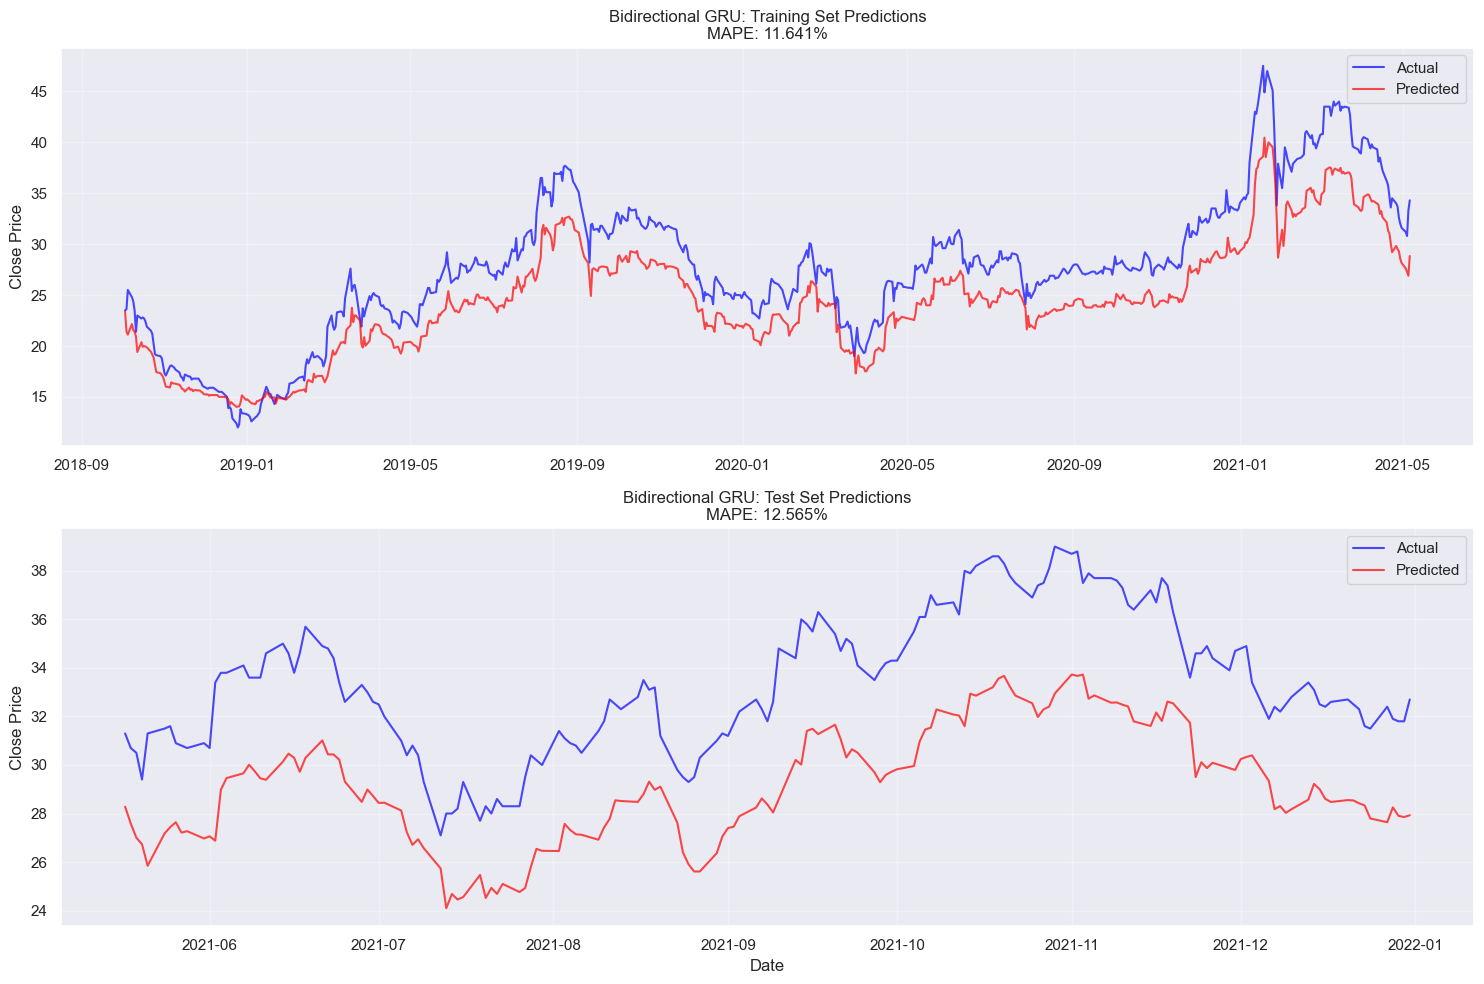

In [37]:
# Plot predictions vs actual values (train/test only)
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Training predictions
axes[0].plot(train_dates, y_train_actual, label='Actual', color='blue', alpha=0.7)
axes[0].plot(train_dates, y_train_pred_actual, label='Predicted', color='red', alpha=0.7)
axes[0].set_title(f'Bidirectional GRU: Training Set Predictions\nMAPE: {train_mape:.3f}%')
axes[0].set_ylabel('Close Price')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test predictions
axes[1].plot(test_dates, y_test_actual, label='Actual', color='blue', alpha=0.7)
axes[1].plot(test_dates, y_test_pred_actual, label='Predicted', color='red', alpha=0.7)
axes[1].set_title(f'Bidirectional GRU: Test Set Predictions\nMAPE: {test_mape:.3f}%')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Close Price')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Model Comparison with Other Architectures

In [38]:
# Compare with other models from MLflow
try:
    # Get current experiment
    experiment = mlflow.get_experiment_by_name("model_experiment")
    
    # Search all runs from this experiment
    runs = mlflow.search_runs(
        experiment_ids=[experiment.experiment_id],
        order_by=["start_time DESC"]
    )
    
    # Filter and display results
    if len(runs) > 0:
        print("🎯 MODEL PERFORMANCE COMPARISON")
        print("=" * 80)
        
        # Select relevant columns for comparison
        comparison_cols = ['run_name', 'run_id', 'params.model_type']
        metric_cols = [col for col in runs.columns if 'metrics.' in col]
        
        display_cols = comparison_cols + metric_cols
        available_cols = [col for col in display_cols if col in runs.columns]
        
        comparison_df = runs[available_cols].copy()
        
        # Clean up column names for display
        for col in comparison_df.columns:
            if col.startswith('metrics.'):
                new_col = col.replace('metrics.', '')
                comparison_df = comparison_df.rename(columns={col: new_col})
            elif col.startswith('params.'):
                new_col = col.replace('params.', '')
                comparison_df = comparison_df.rename(columns={col: new_col})
        
        # Display comparison
        print(comparison_df.to_string(index=False))
        
        # Find best models by test MAPE
        test_mape_cols = [col for col in comparison_df.columns if 'mape_test' in col.lower()]
        if test_mape_cols:
            test_runs = comparison_df.dropna(subset=test_mape_cols)
            if len(test_runs) > 0:
                best_test_run = test_runs.loc[test_runs[test_mape_cols[0]].idxmin()]
                print(f"\n🏆 BEST TEST MODEL: {best_test_run['run_name']} with {best_test_run[test_mape_cols[0]]:.3f}% MAPE")
        
        print(f"\n🔗 View detailed comparison at: http://127.0.0.1:5001")
        
    else:
        print("No previous runs found for comparison")
        
except Exception as e:
    print(f"Error retrieving MLflow runs: {e}")
    print("Make sure MLflow server is running and experiment exists")

🎯 MODEL PERFORMANCE COMPARISON
                          run_id           model_type  mse_test  mape_test  rmse_test  mae_test   r2_test  mape_training  mae_training  r2_training  rmse_training  mse_training  train_rmse  final_train_loss  final_val_loss  train_mse  train_mae  val_rmse    test_r2  test_mape  train_mape  train_r2  test_rmse  test_mse  test_mae   val_mse    val_r2  val_mae  val_mape  val_residual_mape  test_residual_mae  test_residual_mape  test_residual_rmse  val_residual_mse  val_residual_r2  val_residual_rmse  test_residual_mse  test_residual_r2  val_residual_mae
e8a604be282c4a69a13621e8628ce407    Bidirectional GRU 18.425812  12.565253    4.29253  4.206991 -1.317327      11.641191      3.348347     0.721802       3.664173     13.426164         NaN               NaN             NaN        NaN        NaN       NaN        NaN        NaN         NaN       NaN        NaN       NaN       NaN       NaN       NaN      NaN       NaN                NaN                NaN       

# Summary and Next Steps

In [39]:
print("✅ BIDIRECTIONAL GRU MODEL TRAINING COMPLETED")
print("=" * 60)
print(f"Model Architecture: Bidirectional GRU with {NUM_LAYERS} layers")
print(f"Hidden Units: {HIDDEN_SIZE}")
print(f"Time Steps: {TIME_STEPS}")
print(f"Dropout Rate: {DROPOUT_RATE}")
print(f"Training Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")

print("\n📊 PERFORMANCE SUMMARY:")
print(f"Training MAPE: {train_mape:.3f}%")
print(f"Test MAPE: {test_mape:.3f}%")

print("\n🎯 MLflow Tracking:")
print("- Training metrics logged")
print("- Test metrics logged")
print("- Model artifacts saved")
print("\n💡 All metrics use consistent naming for easy comparison with other models!")

✅ BIDIRECTIONAL GRU MODEL TRAINING COMPLETED
Model Architecture: Bidirectional GRU with 1 layers
Hidden Units: 128
Time Steps: 6
Dropout Rate: 0.2
Training Samples: 677
Test Samples: 165

📊 PERFORMANCE SUMMARY:
Training MAPE: 11.641%
Test MAPE: 12.565%

🎯 MLflow Tracking:
- Training metrics logged
- Test metrics logged
- Model artifacts saved

💡 All metrics use consistent naming for easy comparison with other models!
